## Food Image Classification  

Given *images of 101 different foods*, let's try to classifify the **food** present in a given image.

We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.

In [1]:
!kaggle datasets download -d kmader/food41

Dataset URL: https://www.kaggle.com/datasets/kmader/food41
License(s): copyright-authors
100% 5.30G/5.30G [02:16<00:00, 43.3MB/s]
100% 5.30G/5.30G [02:16<00:00, 41.8MB/s]


In [2]:
!unzip /content/food41.zip -d food41

Streaming output truncated to the last 5000 lines.
  inflating: food41/images/tacos/1030289.jpg  
  inflating: food41/images/tacos/1033196.jpg  
  inflating: food41/images/tacos/1036030.jpg  
  inflating: food41/images/tacos/1042175.jpg  
  inflating: food41/images/tacos/1044043.jpg  
  inflating: food41/images/tacos/1058697.jpg  
  inflating: food41/images/tacos/1059239.jpg  
  inflating: food41/images/tacos/1059326.jpg  
  inflating: food41/images/tacos/1066762.jpg  
  inflating: food41/images/tacos/1070967.jpg  
  inflating: food41/images/tacos/1073468.jpg  
  inflating: food41/images/tacos/1075296.jpg  
  inflating: food41/images/tacos/1085243.jpg  
  inflating: food41/images/tacos/108529.jpg  
  inflating: food41/images/tacos/1086014.jpg  
  inflating: food41/images/tacos/108945.jpg  
  inflating: food41/images/tacos/1089575.jpg  
  inflating: food41/images/tacos/1091159.jpg  
  inflating: food41/images/tacos/1101369.jpg  
  inflating: food41/images/tacos/1109058.jpg  
  inflating

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Creating File DataFrame

In [4]:
image_dir = Path('/content/food41/images')

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
image_df

,Filepath,Label
0,/content/food41/images/edamame/2971983.jpg,edamame
1,/content/food41/images/strawberry_shortcake/14...,strawberry_shortcake
2,/content/food41/images/beignets/1523325.jpg,beignets
3,/content/food41/images/baby_back_ribs/119355.jpg,baby_back_ribs
4,/content/food41/images/foie_gras/873597.jpg,foie_gras
...,...,...
10095,/content/food41/images/beef_carpaccio/1210266.jpg,beef_carpaccio
10096,/content/food41/images/carrot_cake/455973.jpg,carrot_cake
10097,/content/food41/images/caesar_salad/538570.jpg,caesar_salad
10098,/content/food41/images/huevos_rancheros/893841...,huevos_rancheros


In [7]:
image_df['Label'].value_counts()

,count
Label,
edamame,100
strawberry_shortcake,100
beignets,100
baby_back_ribs,100
foie_gras,100
...,...
croque_madame,100
pho,100
cheese_plate,100


# Train-Test Split

In [8]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Creating Generators

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


# Modeling

In [11]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,451,493 (9.35 MB)

 Trainable params: 193,509 (755.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


# Training

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - accuracy: 0.0770 - loss: 4.3154 - val_accuracy: 0.3006 - val_loss: 2.8671
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.4063 - loss: 2.3985 - val_accuracy: 0.3996 - val_loss: 2.3648
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5525 - loss: 1.7549 - val_accuracy: 0.4151 - val_loss: 2.3242
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.6308 - loss: 1.3657 - val_accuracy: 0.4427 - val_loss: 2.2281
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.7280 - loss: 1.0279 - val_accuracy: 0.4540 - val_loss: 2.2754
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7826 - loss: 0.8386 - val_accuracy: 0.4279 - val_loss: 2.4051
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.8344 - loss: 0.6445 - val_accuracy: 0.4463 - val_loss: 2.5102


# Results

In [14]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 42.08%


In [15]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step


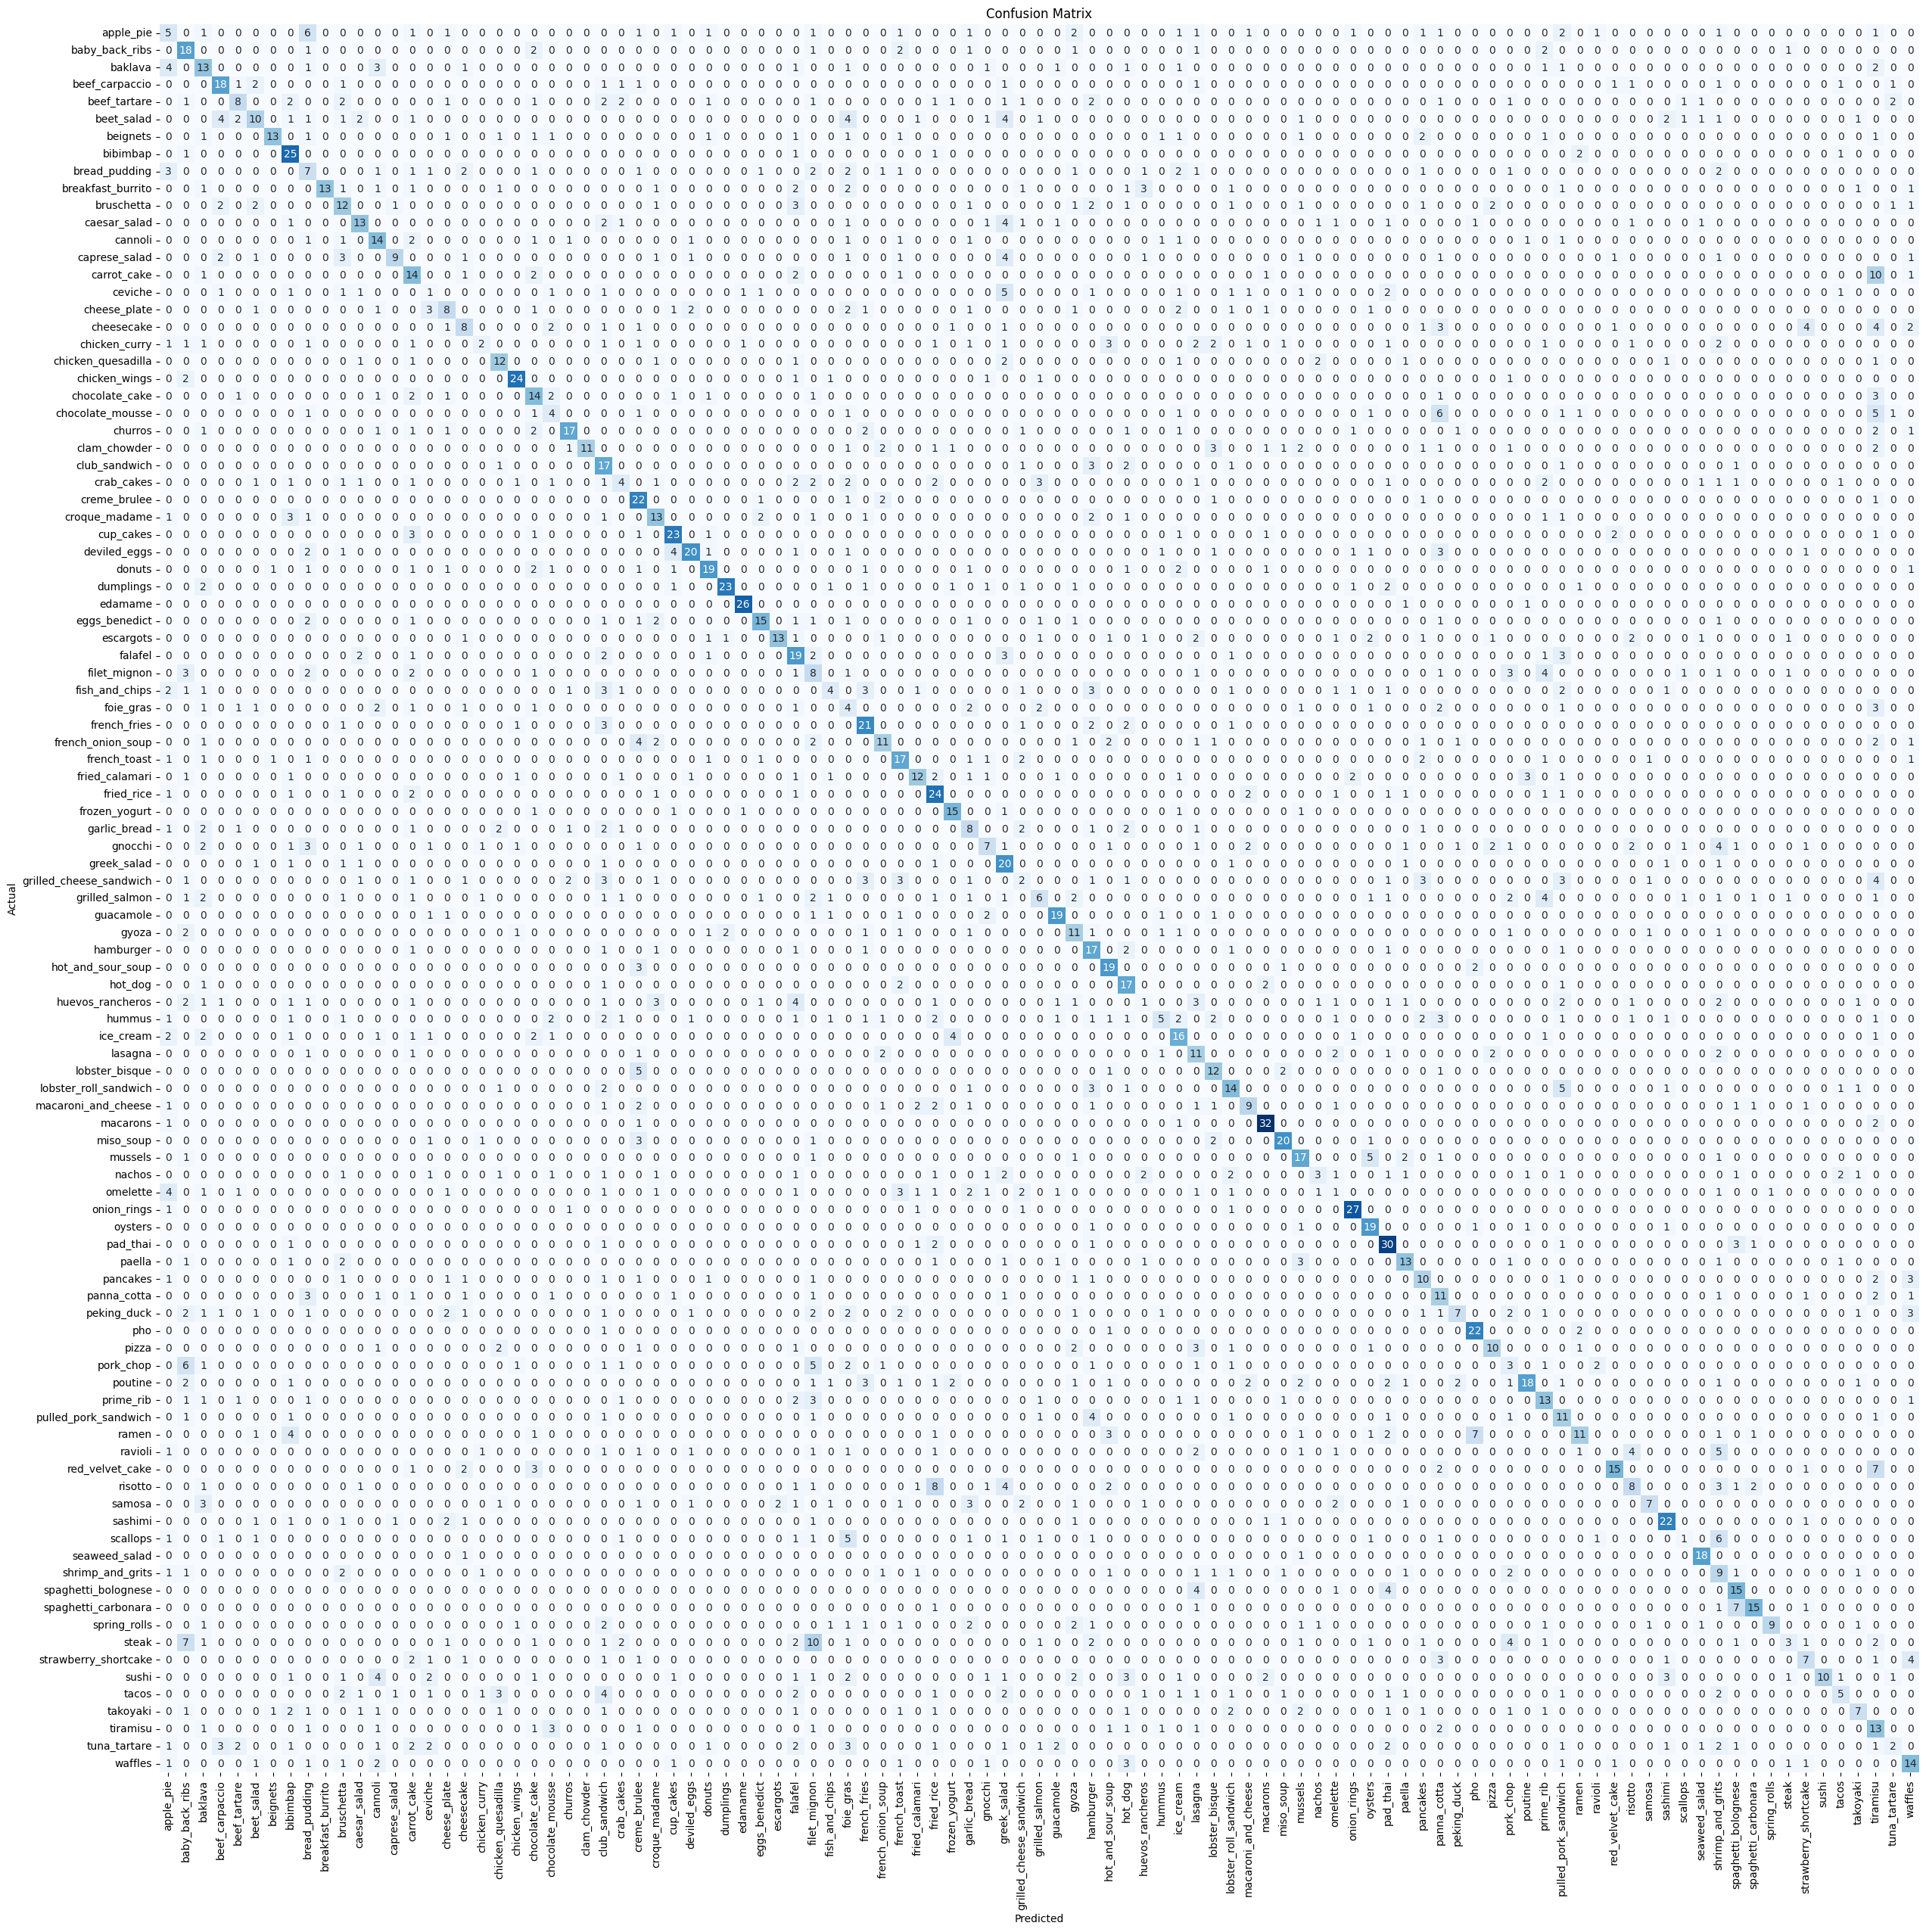

In [16]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.14      0.15      0.15        33
         baby_back_ribs       0.32      0.60      0.41        30
                baklava       0.28      0.41      0.33        32
         beef_carpaccio       0.55      0.56      0.55        32
           beef_tartare       0.44      0.24      0.31        33
             beet_salad       0.42      0.25      0.31        40
               beignets       0.81      0.43      0.57        30
               bibimbap       0.46      0.81      0.59        31
          bread_pudding       0.17      0.21      0.19        33
      breakfast_burrito       1.00      0.41      0.58        32
             bruschetta       0.30      0.36      0.33        33
           caesar_salad       0.50      0.42      0.46        31
                cannoli       0.39      0.50      0.44        28
          caprese_salad       0.75      0.